In [ ]:
!pip install torchinfo

import torchinfo

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [3]:
class DenoisingAE(nn.Module):
  def __init__(self, input_dim):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, 32)
    )

    self.decoder = nn.Sequential(
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, input_dim),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten
])

In [ ]:
mnist_train = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

In [7]:
input_dim = 28 * 28
model = DenoisingAE(input_dim=input_dim)
print(model)

DenoisingAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [8]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
DenoisingAE                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       200,960
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       16,448
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       2,080
├─Sequential: 1-2                        --
│    └─Linear: 2-6                       2,112
│    └─ReLU: 2-7                         --
│    └─Linear: 2-8                       16,640
│    └─ReLU: 2-9                         --
│    └─Linear: 2-10                      201,488
│    └─Sigmoid: 2-11                     --
Total params: 439,728
Trainable params: 439,728
Non-trainable params: 0

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

In [10]:
mnist_train_loader = DataLoader(mnist_train, shuffle=True, batch_size=32)
mnist_test_loader = DataLoader(mnist_test, shuffle=False, batch_size=32)

In [12]:
def add_noise(images, noise_factor=0.7):
  noisy_images = images + noise_factor * torch.randn(*images.shape)
  return torch.clip(noisy_images, 0.0, 1.0)

In [20]:
model.train()

for epoch in range(5):
  total_loss = 0.0
  for data in mnist_train_loader:
    optimizer.zero_grad()
    image, _ = data
    noisy_image = add_noise(image)
    output = model(noisy_image)
    loss = criterion(output, image)

    total_loss += loss.item()
    loss.backward()
    optimizer.step()

  print(f"epoch: {epoch}, loss: {total_loss:.4f}")

epoch: 0, loss: 54.1625
epoch: 1, loss: 50.4932
epoch: 2, loss: 48.3742
epoch: 3, loss: 46.7371
epoch: 4, loss: 45.3754


In [21]:
model.eval()

with torch.no_grad():
  for data in mnist_test_loader:
    image_test, _ = data
    noisy_image_test = add_noise(image_test)
    output_test = model(noisy_image_test)
    break

In [22]:
def visualize(original, noisy, output_test, n=10):
  plt.figure(figsize=(8, 8))

  for i in range(n):
    # original images
    ax = plt.subplot(3, n, i+1)
    plt.imshow(original[i].view(28, 28).numpy(), cmap="gray")
    plt.title("original")
    plt.axis("off")

    # noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy[i].view(28, 28).numpy(), cmap="gray")
    plt.title("noisy", fontsize=10, rotation=45)

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(output_test[i].view(28, 28).numpy(), cmap="gray")
    plt.title("reconstructed", fontsize=10, rotation=45)
    plt.axis("off")

  plt.show()

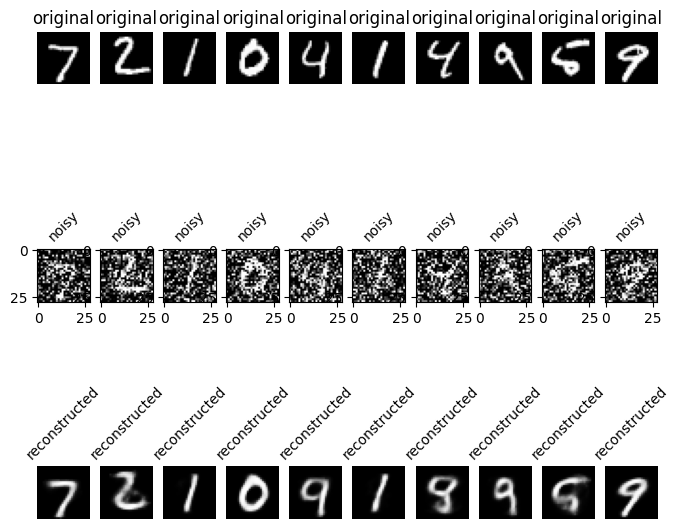

In [23]:
visualize(image_test, noisy_image_test, output_test)